In this notebook the trained energy predictors for each layer-type are tested against real world measurements of various architectures.

In [1]:
import pandas as pd
import yaml
import sys
sys.path.append('../')
import seaborn as sns
sns.set(font_scale=1.2)
import torchvision.models as models
from matplotlib import pyplot as plt
from utils.data_utils import preprocess_and_normalize_energy_data, parse_codecarbon_output
from utils.architecture_utils import get_modules_from_architecture
from run_estimation import compute_energy_estimate
from sklearn.metrics import r2_score
%load_ext autoreload
%autoreload 2
pd.set_option("display.precision", 5)

# Custom Definitions

In [2]:
# dictionary of architecture names and their PyTorch instances
architectures_dict = {
    'alexnet': models.alexnet(weights=None),
    'vgg13': models.vgg13(weights=None),
    'vgg11': models.vgg11(weights=None),
    'vgg16': models.vgg16(weights=None),
    'resnet18': models.resnet18(weights=None),
    'resnet34': models.resnet34(weights=None),
    'resnet50': models.resnet50(weights=None)
}

# Data Preparation
## Load Data & Normalize

In [3]:
d1 = parse_codecarbon_output(
    '../data/architectures/00_architectures-layerwise-raw.csv',
    False,
    ('../data/architectures/00_architectures-layerwise-slurm-log.out','architectures',False,3)
)
print("dataset shape:", d1.shape)

Dropped observations with the following indices: [83, 267, 385, 451, 605, 632, 818, 832, 989, 1175, 1269, 1366, 1500, 1730, 1752, 1942, 1958, 2130, 2184, 2316, 2410, 2506, 2639, 2694, 2878, 3062, 3082, 3239, 3300, 3424, 3514, 3733]
dataset shape: (3748, 28)


In [4]:
d2 = parse_codecarbon_output(
    '../data/architectures/01_architectures-layerwise-raw.csv',
    False,
    ('../data/architectures/01_architectures-layerwise-slurm-log.out','architectures',False,3)
)
print("dataset shape:", d2.shape)

Dropped observations with the following indices: [68, 199, 259, 430, 450, 642, 661, 824, 882, 1109, 1200, 1387, 1561, 1571, 1747, 1930, 1999]
dataset shape: (2053, 28)


In [5]:
df_unnormalized = pd.concat([d1,d2])
# normalize
df = preprocess_and_normalize_energy_data(df_unnormalized,['module','batch_size','architecture','layer_idx'], aggregate=True, verbose=True)
df["layer_idx"] = pd.to_numeric(df['layer_idx'])
print("Measured models:", df.architecture.unique())
df.head(n=15)

Shape before aggregation: (5801, 28), after aggregation: (1840, 20) (non numeric columns removed)
Final shape of data set: (1840, 20)
Measured models: ['vgg16' 'alexnet' 'vgg11' 'vgg13']


,module,batch_size,architecture,layer_idx,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,gpu_energy,ram_energy,energy_consumed,cpu_count,gpu_count,ram_total_size,rep_no,macs,forward_passes
0,VGG,194,vgg16,0,86.18856,0.00276,0.03200,75.64075,30.34967,288.75,1.80256e-03,7.23151e-04,6.63812e-03,9.16383e-03,2.0,1.0,770.0,2.0,3.00768e+12,1.00000
1,Conv2d,194,vgg16,1,30.62115,0.00098,0.03197,73.22508,30.50433,288.75,7.08974e-05,2.87355e-05,2.61707e-04,3.61340e-04,2.0,1.0,770.0,2.0,1.74436e+10,9.00000
2,ReLU,194,vgg16,2,30.21828,0.00105,0.03478,76.65783,30.31633,288.75,4.51689e-06,1.70854e-06,1.72609e-05,2.34863e-05,2.0,1.0,770.0,2.0,6.22985e+08,148.66667
3,Conv2d,194,vgg16,3,36.40757,0.00117,0.03200,73.98323,30.39067,288.75,2.54487e-04,1.01905e-04,9.33769e-04,1.29016e-03,2.0,1.0,770.0,2.0,3.59462e+11,3.00000
4,ReLU,194,vgg16,4,30.13623,0.00100,0.03325,79.94049,30.74800,288.75,4.51936e-06,1.72944e-06,1.62401e-05,2.24889e-05,2.0,1.0,770.0,2.0,6.22985e+08,148.00000
5,MaxPool2d,194,vgg16,5,32.94678,0.00106,0.03207,75.06948,30.14233,288.75,6.87384e-05,2.76325e-05,2.54711e-04,3.51082e-04,2.0,1.0,770.0,2.0,3.11493e+08,10.00000
6,Conv2d,194,vgg16,6,32.31144,0.00104,0.03206,75.50851,30.52633,288.75,1.12810e-04,4.55238e-05,4.15226e-04,5.73560e-04,2.0,1.0,770.0,2.0,1.79731e+11,6.00000
7,ReLU,194,vgg16,7,30.08751,0.00098,0.03244,80.01597,30.38800,288.75,2.24323e-06,8.42973e-07,7.79546e-06,1.08817e-05,2.0,1.0,770.0,2.0,3.11493e+08,298.00000
8,Conv2d,194,vgg16,8,38.76800,0.00124,0.03205,75.12099,30.69033,288.75,2.02678e-04,8.19778e-05,7.47389e-04,1.03204e-03,2.0,1.0,770.0,2.0,3.59151e+11,4.00000
9,ReLU,194,vgg16,9,30.06146,0.00098,0.03247,80.02730,30.32533,288.75,2.23555e-06,8.49981e-07,7.77362e-06,1.08592e-05,2.0,1.0,770.0,2.0,3.11493e+08,298.66667


## Ensuring that module-wise observations are complete for every architecture and batch-size

In [6]:
for a in df.architecture.unique():
    sub = df.loc[df.architecture == a]
    num_modules_a = len(get_modules_from_architecture(architectures_dict[a]))
    for b in sub.batch_size.unique():
        sub_b = sub.loc[sub.batch_size == b]
        if num_modules_a+1 - len(sub_b) != 0:
            print(f"removing all observations from {a} with batch_size {b}")
            df = df.drop(index=sub_b.index)
print("Final data-shape: ", df.shape)

Final data-shape:  (1840, 20)


## Check if there are large deviations between the accumulated layer-wise energy and the complete architecture energy measurement

In [7]:
# compute % contribution
architecture_wise_deviations = pd.DataFrame(columns=['architecture', 'batch_size', 'percent_deviation', 'total_agg_energy','measured_energy'])
for a in df.architecture.unique():
    # subset data by architecture
    sub = df.loc[df.architecture == a]
    for b in sub.batch_size.unique():
        # subset data by batch_size
        sub_b = sub.loc[sub.batch_size == b]
        # get energy from complete architecture run
        total_measured_energy = sub_b.loc[sub_b.layer_idx == 0].cpu_energy.item()
        # subset only data from individual modules of architecture
        sub_b_modules = sub_b.loc[sub_b.layer_idx != 0]
        # compute empirical total energy from complete architecture run by summing up modules
        total_agg_energy = sum(sub_b_modules.groupby(['architecture', 'batch_size', 'module'])['cpu_energy'].sum().reset_index().cpu_energy)
        new_row = {'architecture':a, 'batch_size':b, 'percent_deviation':(total_agg_energy - total_measured_energy) / total_agg_energy, 'total_agg_energy':total_agg_energy,'measured_energy':total_measured_energy}
        architecture_wise_deviations = pd.concat([architecture_wise_deviations, pd.DataFrame(new_row,index=[0])], ignore_index=True)
# print avg energies; compare energy when running the full architecture vs summing the energy over the individual modules
agg = architecture_wise_deviations.groupby(['architecture']).mean()
agg.columns = [f"mean_{col_name}" for col_name in agg.columns]
agg

,mean_percent_deviation,mean_total_agg_energy,mean_measured_energy
architecture,,,
alexnet,0.00291,0.00005,0.00005
vgg11,0.01172,0.00048,0.00048
vgg13,0.00735,0.00097,0.00096
vgg16,0.00532,0.00130,0.00129


Text(0, 0.5, 'consumed energy')

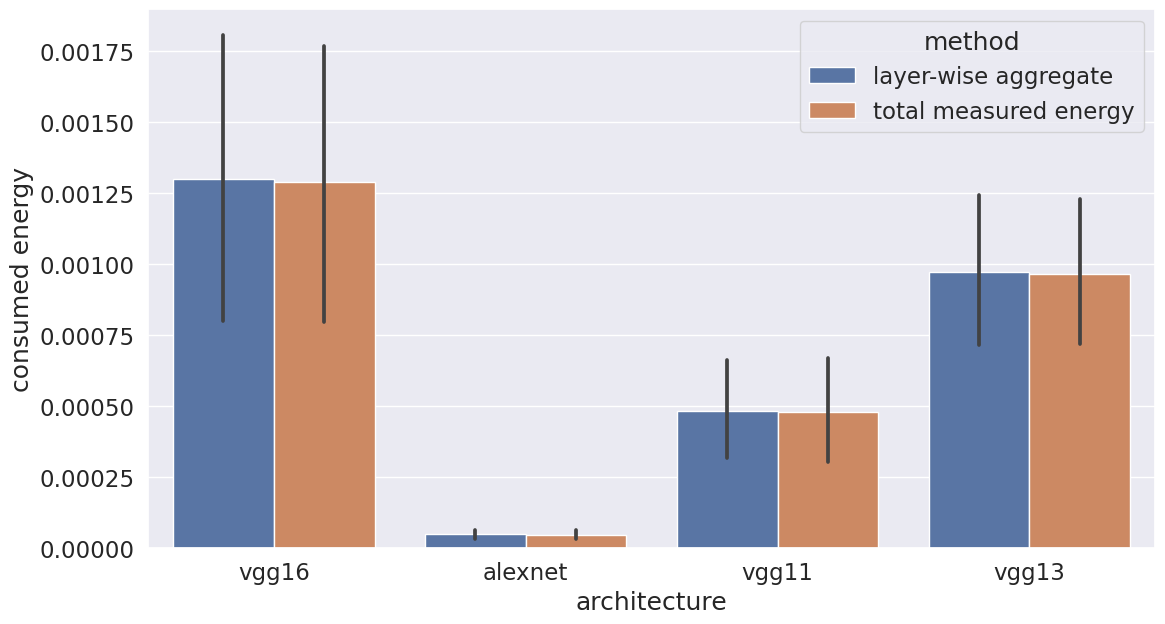

In [8]:
# create a plot to compare layer-wise and complete measurements energy data, to inspect deviations visually
sns.set(font_scale=1.5)
plt.figure(figsize=(13,7))
to_plot = architecture_wise_deviations.rename(columns={"total_agg_energy": "layer-wise aggregate", 'measured_energy':'total measured energy'})
to_plot = pd.melt(to_plot, id_vars=['architecture','batch_size'], value_vars=['percent_deviation','layer-wise aggregate','total measured energy'],var_name='method')
g = sns.barplot(data=to_plot.loc[to_plot.method != 'percent_deviation'], x="architecture", hue="method", y="value")
g.set_xlabel("architecture")
g.set_ylabel("consumed energy")

In [9]:
# check for deviations that are too big
# and remove bad measurements with high deviations
blacklist = []
data = df.copy()
for idx, row in architecture_wise_deviations.iterrows():
    if abs(row.percent_deviation) > 0.9:
        blacklist.append({'architecture': row.architecture, 'batch_size': row.batch_size})
if len(blacklist) != 0:
    print("WARNING: measurements with large deviations (>10%) detected. Corresponding observations will be removed!")
    print("Number of blacklisted configurations: ", len(blacklist))
    # remove measurements where the deviations are too big
    data_shape = data.shape
    for config in blacklist:
        data = data.loc[~(data[list(config)] == pd.Series(config)).all(axis=1)]
    print(f"A total of {data_shape[0]-data.shape[0]} rows have been removed.")
else:
    print("No bad measurements found!")

No bad measurements found!


# Predictions
## Load configuration

In [10]:
# load config
with open('../model_fitting_and_estimation_config.yaml', "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## Compute full architecture and channel-wise predictions

In [11]:
full_architecture_preds = pd.DataFrame(columns=["y", "y_hat", "batch_size", "architecture"])
channel_wise_preds = pd.DataFrame(columns=["y", "y_hat", "batch_size", "architecture", "module", "layer_idx", "sanity"])
data = df

for a_name, architecture in architectures_dict.items():
    # get data for the model
    data_a = data.loc[data['architecture'] == a_name].copy()
    data_a.reset_index(drop=True)

    # compute the predictions for the entire model
    # for all batch-sizes that were sampled
    for batch_size in data_a.batch_size.unique():
        # parse model structure and return list of channels
        total_predicted_energy, channel_wise_energies = compute_energy_estimate(architecture=architecture,
                                                                                batch_size=batch_size,
                                                                                config=config["model_configurations"])
        # sub-select corresponding to batch_size
        data_a_batch_size = data_a.loc[data_a.batch_size == batch_size]
        # sub-select the measurement that corresponds to the entire row
        a_measurement = data_a_batch_size.loc[data_a_batch_size.layer_idx == 0].copy()

        new_row = {
            "y": [a_measurement.cpu_energy.item()],
            "y_hat": [total_predicted_energy[0]],
            "batch_size": [batch_size],
            "architecture": [a_name]
        }
        full_architecture_preds = pd.concat([full_architecture_preds, pd.DataFrame(new_row)], ignore_index=True)

        # parse and combine local energy predictions with measurements
        # sub-select from dataframe
        data_a_compwise = data_a_batch_size.loc[data_a_batch_size.layer_idx != 0]
        if len(data_a_compwise) != 0:
            # remove Dropout and Adaptive Pooling layers
            # data_a_compwise = data_a_compwise.loc[~((data_a_compwise.module == "AdaptiveAvgPool2d") | (data_a_compwise.module == "Dropout"))]
            data_a_compwise.reset_index(inplace=True, drop=True)
            for idx, row in data_a_compwise.iterrows():
                new_row = {
                    "y": row.cpu_energy,
                    "y_hat": channel_wise_energies[idx][1],
                    "batch_size": batch_size,
                    "architecture": a_name,
                    "module": row.module,
                    "layer_idx": row.layer_idx,
                    "sanity": channel_wise_energies[idx][0]
                }
                channel_wise_preds = pd.concat([channel_wise_preds, pd.DataFrame(new_row,index=[0])], ignore_index=True)

WARN: Skipping Layer: No EnergyChannel implemented for AdaptiveAvgPool2d(output_size=(6, 6))
WARN: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
WARN: Skipping Layer: No EnergyChannel implemented for Dropout(p=0.5, inplace=False)
Loading preprocessors for Conv2dEnergyChannel...
    No preprocessor found.
Loading postprocessor for Conv2dEnergyChannel...
    No postprocessor-version was specified. Loading most recent model.
    Loaded postprocessor --- 2023-02-04_conv2dEnergyChannel_MinMaxScaler.joblib for Conv2dEnergyChannel
Loading model for Conv2dEnergyChannel...
    No model-version was specified. Loading most recent model.
    Loaded model --- 2023-02-04_conv2dEnergyChannel_LinearRegression.joblib for Conv2dEnergyChannel
Loading preprocessors for ReLUEnergyChannel...
    No preprocessor found.
Loading postprocessor for ReLUEnergyChannel...
    No postprocessor-version was specified. Loading most recent model.
    Loaded postprocessor --- 2023-02-04_r

# Analyze Results
# Complete architecture estimates

In [12]:
# metrics
r2 = r2_score(full_architecture_preds.y, full_architecture_preds.y_hat)
print("Overall total R2-Score: ", r2)
for a_name, architecture in architectures_dict.items():
    # sub-select predictions by model
    full_prediction_single_model = full_architecture_preds.loc[full_architecture_preds.architecture == a_name]
    if len(full_prediction_single_model) == 0:
        continue
    print("-----------")
    percent_deviation = abs(full_prediction_single_model.y_hat - full_prediction_single_model.y) / full_prediction_single_model.y
    print(a_name)
    print(f"R2-Score: ",r2_score(full_prediction_single_model.y, full_prediction_single_model.y_hat))
    print(f"Avg-Abs-%-Deviation: {percent_deviation.mean():.2%}")

Overall total R2-Score:  0.35237140371212183
-----------
alexnet
R2-Score:  -66.65656226746259
Avg-Abs-%-Deviation: 1486.50%
-----------
vgg13
R2-Score:  -0.15856061320089587
Avg-Abs-%-Deviation: 159.03%
-----------
vgg11
R2-Score:  -0.44535830005706045
Avg-Abs-%-Deviation: 274.63%
-----------
vgg16
R2-Score:  -0.044104094083287526
Avg-Abs-%-Deviation: 116.14%


In [13]:
sns.set(font_scale=1.5)

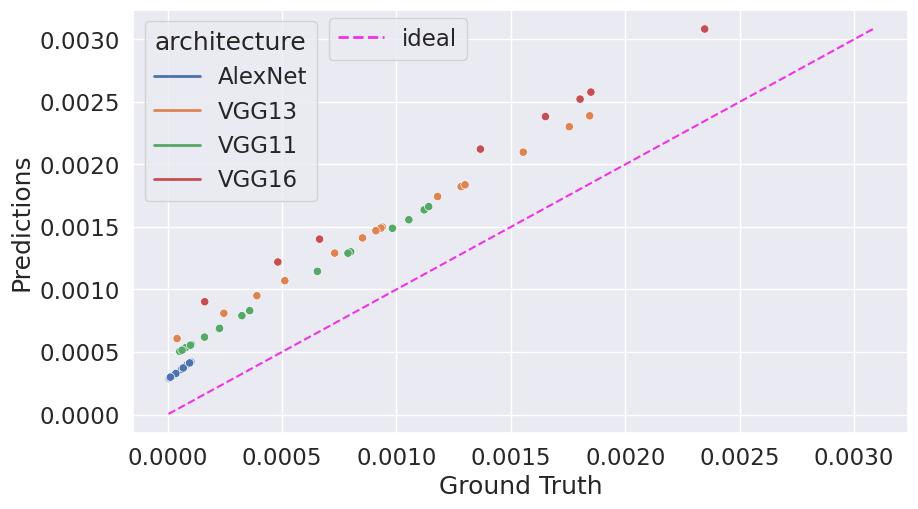

In [14]:
plt.figure(figsize=(10,5.5))
g = sns.scatterplot(data=full_architecture_preds, x="y", y="y_hat", hue="architecture",palette=["#4C72B0","#DD8452","#55A868","#C44E52"])
min_x = min(min(full_architecture_preds.y), min(full_architecture_preds.y_hat))
max_x = max(max(full_architecture_preds.y), max(full_architecture_preds.y_hat))
g.plot([min_x, max_x], [min_x, max_x], transform=g.transData, linestyle="--", color="#f032e6")
g.set_xlabel("Ground Truth")
g.set_ylabel("Predictions")
custom_lines = [
                plt.Line2D([0], [0], color="#4C72B0", lw=2),
                plt.Line2D([0], [0], color="#DD8452", lw=2),
                plt.Line2D([0], [0], color="#55A868", lw=2),
                plt.Line2D([0], [0], color="#C44E52", lw=2),
]
custom_lines2 = [plt.Line2D([0], [0], color="#f032e6", lw=2, linestyle="--")]
legend2 = g.legend(custom_lines2, ["ideal"], bbox_to_anchor=(0.43, 0.980), loc='upper right', borderaxespad=0.)
g.add_artist(legend2)
plt.legend(custom_lines, ['AlexNet', 'VGG13', 'VGG11', 'VGG16'], title="architecture", loc="best")

# Channel-wise estimates


Conv2d
R2-Score:  0.3146719861836569
Avg-Abs-%-Deviation: 735.22%


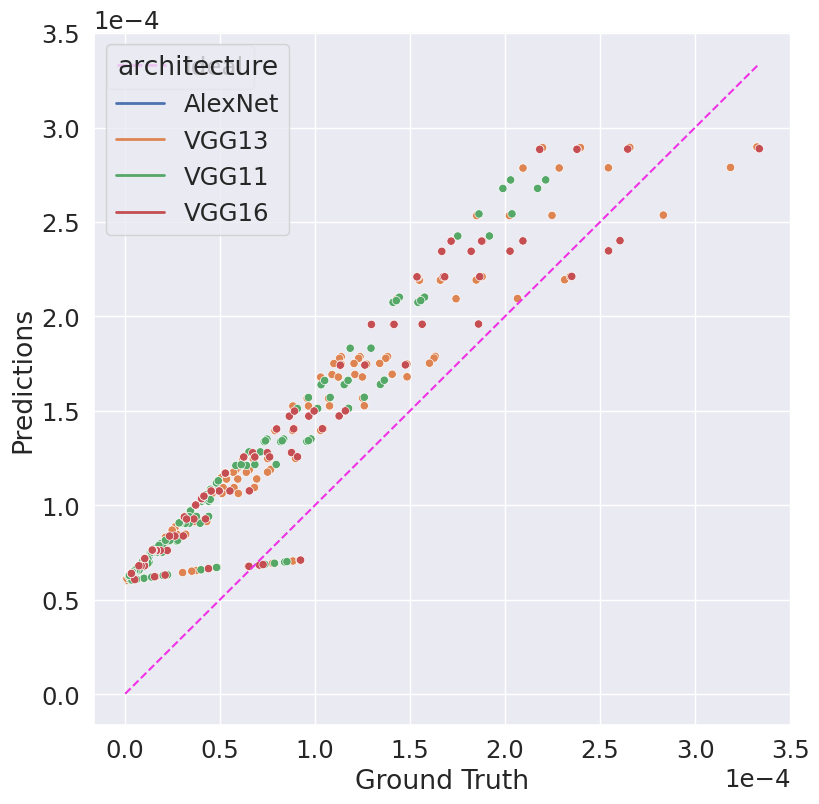

ReLU
R2-Score:  -21.51064705159846
Avg-Abs-%-Deviation: 75011.80%


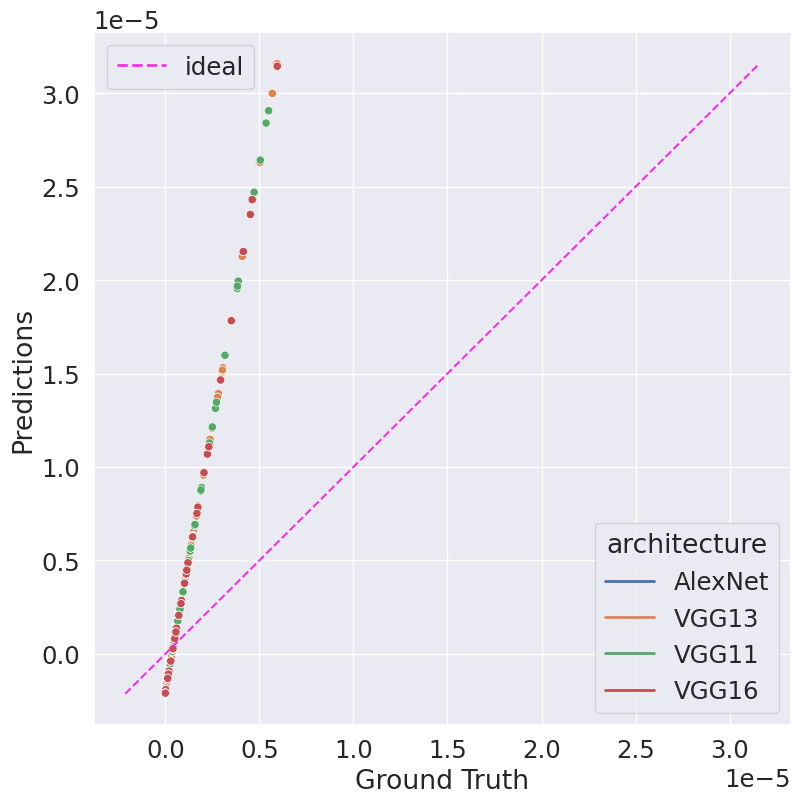

MaxPool2d
R2-Score:  0.5592786146726472
Avg-Abs-%-Deviation: 530.42%


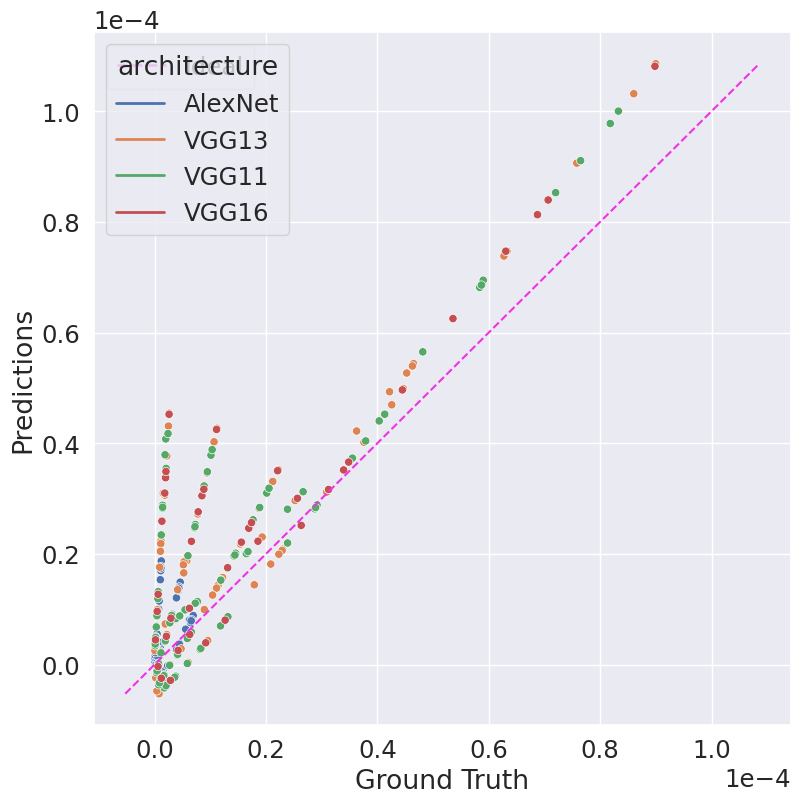

AdaptiveAvgPool2d
R2-Score:  -1.535495247838424
Avg-Abs-%-Deviation: 100.00%


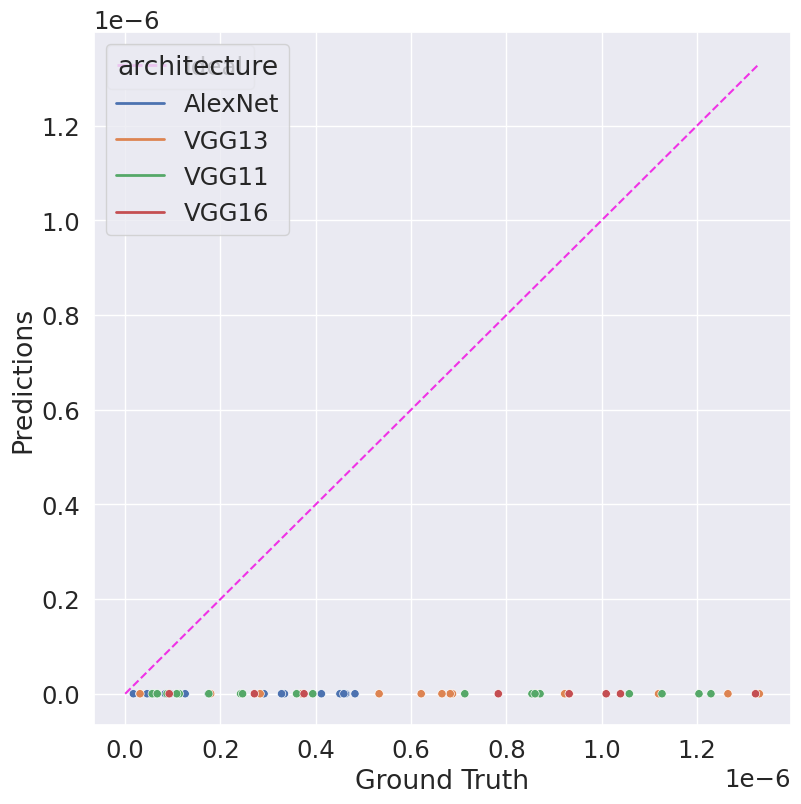

Dropout
R2-Score:  -665.0544949529183
Avg-Abs-%-Deviation: 100.00%


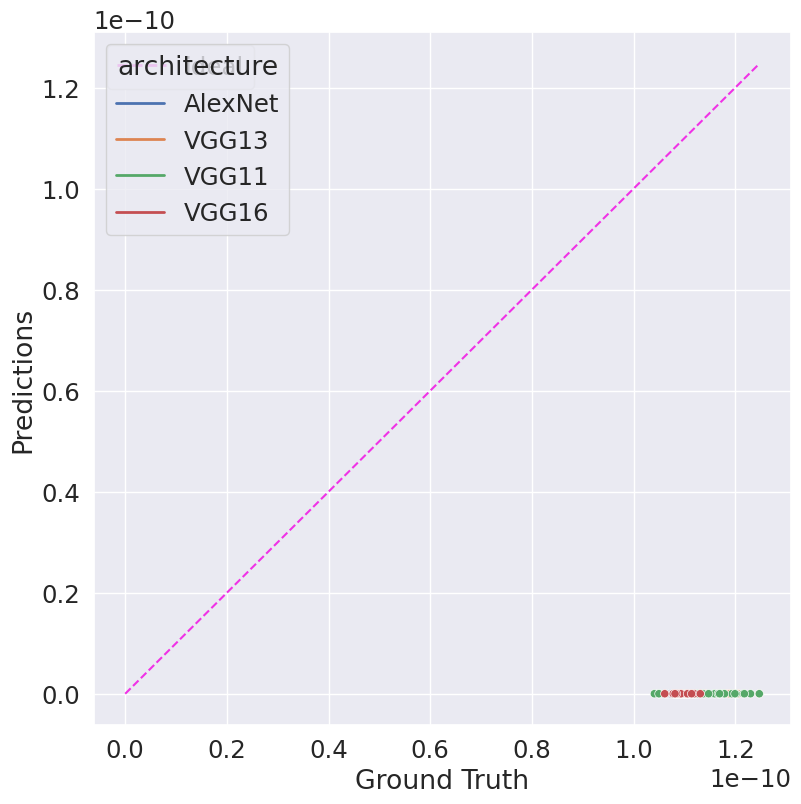

Linear
R2-Score:  0.9770479813263381
Avg-Abs-%-Deviation: 16.70%


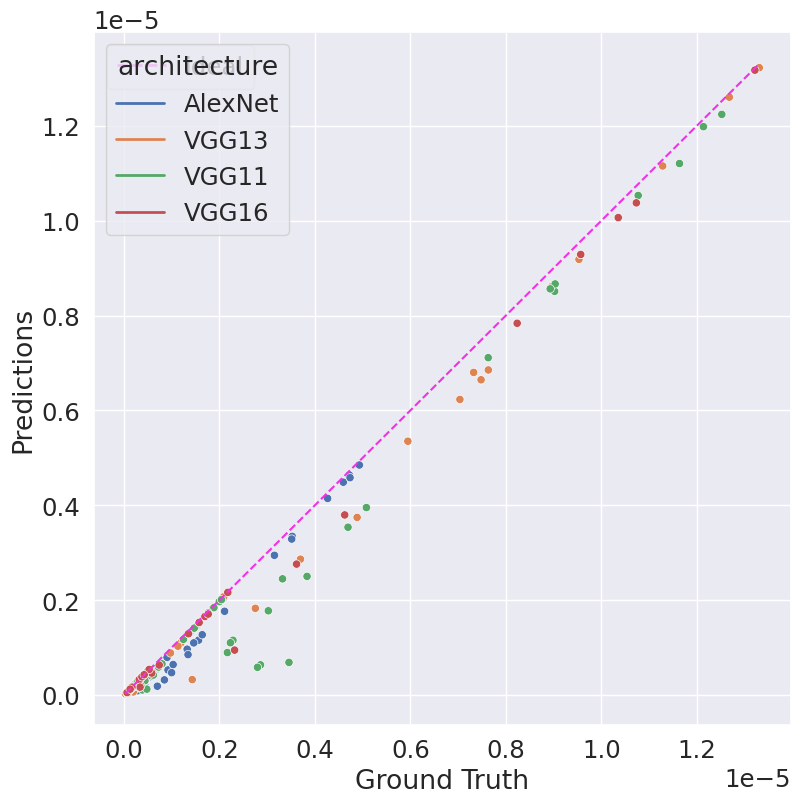

In [15]:
sns.set(font_scale=1.6)
for channel_type in channel_wise_preds.module.unique():
    channel_preds = channel_wise_preds.loc[channel_wise_preds.module == channel_type]
    percent_deviation = abs(channel_preds.y_hat - channel_preds.y) / channel_preds.y
    print(channel_type)
    print(f"R2-Score: ", r2_score(channel_preds.y, channel_preds.y_hat))
    print(f"Avg-Abs-%-Deviation: {percent_deviation.mean():.2%}")
    plt.figure(figsize=(9,9))
    g = sns.scatterplot(data=channel_preds, x="y", y="y_hat", hue="architecture", palette=["#4C72B0", "#DD8452", "#55A868", "#C44E52"])
    plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    min_x = min(min(channel_preds.y), min(channel_preds.y_hat))
    max_x = max(max(channel_preds.y), max(channel_preds.y_hat))
    g.plot([min_x, max_x], [min_x, max_x], transform=g.transData, linestyle="--", color="#f032e6")
    g.set_xlabel("Ground Truth")
    g.set_ylabel("Predictions")
    custom_lines = [
                    plt.Line2D([0], [0], color="#4C72B0", lw=2),
                    plt.Line2D([0], [0], color="#DD8452", lw=2),
                    plt.Line2D([0], [0], color="#55A868", lw=2),
                    plt.Line2D([0], [0], color="#C44E52", lw=2),
    ]
    custom_lines2 = [plt.Line2D([0], [0], color="#f032e6", lw=2, linestyle="--")]
    legend2 = g.legend(custom_lines2, ["ideal"], bbox_to_anchor=(0.234, 0.985), loc='upper right', borderaxespad=0.1)
    g.add_artist(legend2)
    plt.legend(custom_lines, ['AlexNet', 'VGG13', 'VGG11', 'VGG16'], title="architecture", loc="best")
    plt.show()